In [23]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [24]:
dataset = './keypoint.csv'
model_save_path = './keypoint_classifier.hdf5'
tflite_save_path = './keypoint_classifier.tflite'

# Set number of classes

In [25]:
NUM_CLASSES = 8

# Dataset reading

In [76]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 3) + 1)))

In [77]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [79]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(63, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [80]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_10 (Dropout)        (None, 63)                0         
                                                                 
 dense_14 (Dense)            (None, 63)                4032      
                                                                 
 dropout_11 (Dropout)        (None, 63)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                2048      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 8)                

In [81]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [82]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [83]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
27/30 [==========================>...] - ETA: 0s - loss: 2.1459 - accuracy: 0.1435 
Epoch 1: saving model to .\keypoint_classifier.hdf5
30/30 [==============================] - 1s 11ms/step - loss: 2.1386 - accuracy: 0.1417 - val_loss: 2.0426 - val_accuracy: 0.1875
Epoch 2/1000
25/30 [========================>.....] - ETA: 0s - loss: 2.0707 - accuracy: 0.1550
Epoch 2: saving model to .\keypoint_classifier.hdf5
30/30 [==============================] - 0s 6ms/step - loss: 2.0669 - accuracy: 0.1604 - val_loss: 2.0114 - val_accuracy: 0.1875
Epoch 3/1000
18/30 [=================>............] - ETA: 0s - loss: 1.9949 - accuracy: 0.2292
Epoch 3: saving model to .\keypoint_classifier.hdf5
30/30 [==============================] - 0s 5ms/step - loss: 2.0013 - accuracy: 0.2229 - val_loss: 1.9548 - val_accuracy: 0.3250
Epoch 4/1000
23/30 [======================>.......] - ETA: 0s - loss: 1.9604 - accuracy: 0.2011
Epoch 4: saving model to .\keypoint_classifier.hdf5
30/30 [============

In [84]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 1s 4ms/step - loss: 0.3197 - accuracy: 0.9375


In [85]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [86]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 85ms/step
[7.9808749e-02 1.0991220e-05 9.7143720e-06 8.8518085e-05 5.5134431e-03
 9.4102448e-05 2.2288989e-02 8.9218557e-01]
7


# Confusion matrix

5/5 [==============================] - 0s 2ms/step


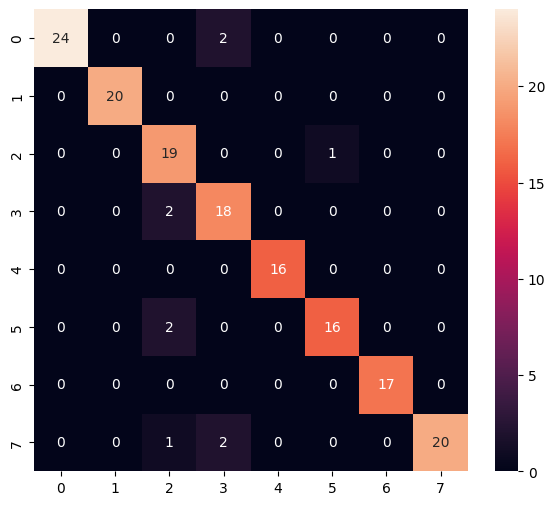

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       1.00      1.00      1.00        20
           2       0.79      0.95      0.86        20
           3       0.82      0.90      0.86        20
           4       1.00      1.00      1.00        16
           5       0.94      0.89      0.91        18
           6       1.00      1.00      1.00        17
           7       1.00      0.87      0.93        23

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160



In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [88]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [89]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\moham\AppData\Local\Temp\tmp2idk64ss\assets


INFO:tensorflow:Assets written to: C:\Users\moham\AppData\Local\Temp\tmp2idk64ss\assets


11728

# Inference test

In [90]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [91]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [92]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [93]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 999 µs


In [94]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.2761519e-02 1.1402755e-05 1.0121455e-05 9.6473304e-05 5.6721224e-03
 9.5173928e-05 2.2989953e-02 8.8836324e-01]
7
